# Loading the dataset

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [ ]:
data_dir = 'data'
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Ensemble Technique

In [ ]:
# Simple CNN Network, deterministic
class CNN_MNIST(nn.Module):
    def __init__(self, dim1 = 128, dim2 = 64):
        super(CNN_MNIST, self).__init__()
        self.cn1 = nn.Conv2d(in_channels= 1, out_channels = 64 , kernel_size=(3,3))
        self.cn2 = nn.Conv2d(in_channels= 64, out_channels = 32 , kernel_size=(3,3))
        self.mp1 = nn.MaxPool2d((3,3))

        self.fc1 = nn.Linear(2048, dim1)
        self.fc2 = nn.Linear(dim1, dim2)
        self.fc3 = nn.Linear(dim2, 10)
        self.ls = nn.LogSoftmax(1)
        
    def forward(self, x):
        y = torch.relu(self.cn1(x))
        y = torch.relu(self.cn2(y))
        y = self.mp1(y)
        y = torch.flatten(y , start_dim = 1)
        y = torch.tanh(self.fc1(y))
        y = torch.tanh(self.fc2(y))
        y = self.fc3(y)
        y = self.ls(y)
        return y

In [ ]:
M = 1
num_epochs = 10
models = []

for m in range(M):
  # Start training
  model = CNN_MNIST().to(device)
  model.train()
  optimizer = torch.optim.Adam(model.parameters())
  loss = torch.nn.NLLLoss()
  for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_loader):
      # Forward pass
      x = x.to(device)
      y = y.to(device)

      y_pred = model(x)

      output = loss(y_pred, y)

      optimizer.zero_grad()
      output.backward()
      optimizer.step()
        
      if i == 0:
        print ("Epoch[{}/{}], loss: {:.4f}" .format(epoch+1, num_epochs, output.item()))
  models.append(model)

Epoch[1/1], loss: 2.3001


torch.Size([1, 1, 28, 28])


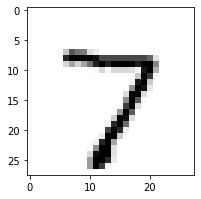

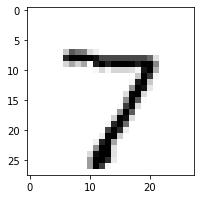

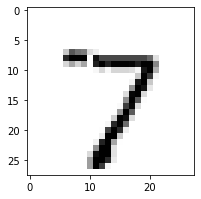

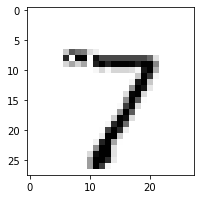

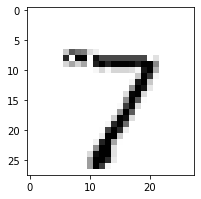

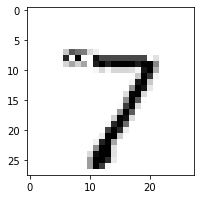

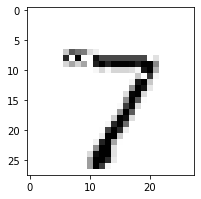

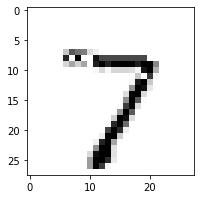

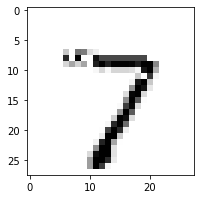

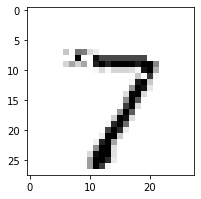

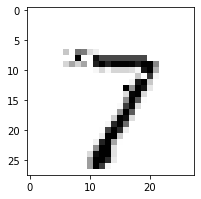

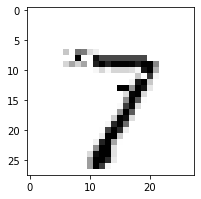

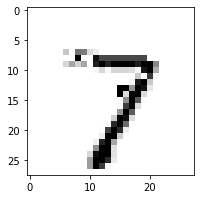

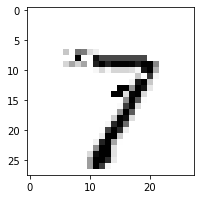

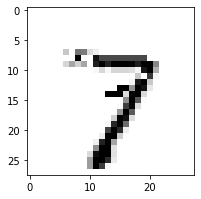

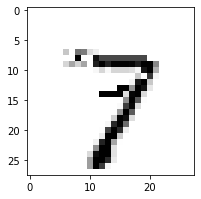

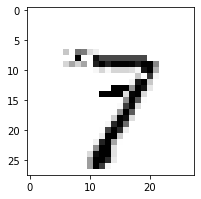

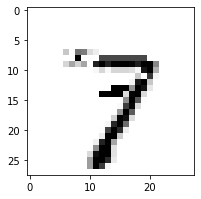

17


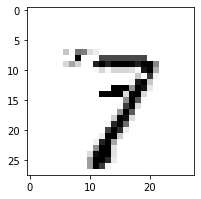

In [ ]:
def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, cmap='Greys', interpolation=None if interp else 'none')
    plt.show()

K = 1
image = iter(test_loader).next()[0][0]
image = image.unsqueeze(0)
print(image.shape)
plot(image.detach().numpy()[0][0])
continue_it = True
nb_iter = 0
image = image.to(device)
image.requires_grad = True

mask = np.zeros((1,10))
mask[0, 9] = 1
mask = torch.tensor(mask).float().to(device)

while(continue_it) :
  image.requires_grad = True
  y = models[0](image)
  for i in range(1,K) :
    y.add(models[i](image))
  loss = y.mm(mask.t())
  loss.backward()
  im_grad = image.grad

  if np.argmax(y.cpu().detach().numpy()) == 9:
    continue_it = False
    print(nb_iter)
  
  nb_iter += 1
  with torch.no_grad():
    bow = torch.sign(image - torch.mean(image))
    grada = bow*im_grad
    ptbc = torch.argmin(grada)
    tensor = torch.zeros(image.shape).to(device)
    a = ptbc // 28
    b = ptbc % 28
    tensor[0, 0,  a, b] = 1
    gradient_sign = (2 * (im_grad >= 0) - 1).type(torch.float).to(device) # renvoie 1 si le gradient est positif, -1 s'il est négatif
    perturbed_image = image + 1 * gradient_sign * tensor
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clip(perturbed_image, 0, 1).to(device)
    image = perturbed_image

  for m in models:
    m.zero_grad()
  plot(image.cpu().detach().numpy()[0][0])

Every image is a challenge to attack ! Here are the results :

19 (from 7 to 9)

26 (from 2 to 9)

34 (from 1 to 9)

inf (from 0 to 9)

4 (from 4 to 9)

inf (from 1 to 9)

15 (from ? to 9)


# MC Dropout

In [ ]:
# Simple CNN Network, deterministic
class dropout_MNIST(nn.Module):
    def __init__(self, dim1 = 128, dim2 = 64, p_d = 0.2):
        super(dropout_MNIST, self).__init__()
        self.cn1 = nn.Conv2d(in_channels= 1, out_channels = 64 , kernel_size=(3,3))
        self.dr1 = nn.Dropout2d(p = p_d)
        self.cn2 = nn.Conv2d(in_channels= 64, out_channels = 32 , kernel_size=(3,3))
        self.dr2 = nn.Dropout2d(p = p_d)
        self.mp1 = nn.MaxPool2d((3,3))

        self.fc1 = nn.Linear(2048, dim1)
        self.fc2 = nn.Linear(dim1, dim2)
        self.fc3 = nn.Linear(dim2, 10)
        self.ls = nn.LogSoftmax(1)
        
    def forward(self, x):
        y = torch.relu(self.cn1(x))
        y = self.dr1(y)
        y = torch.relu(self.cn2(y))
        y = self.dr2(y)
        y = self.mp1(y)
        y = torch.flatten(y , start_dim = 1)
        y = torch.tanh(self.fc1(y))
        y = torch.tanh(self.fc2(y))
        y = self.fc3(y)
        y = self.ls(y)
        return y

model_dropout = dropout_MNIST().to(device)
model_dropout.train()
optimizer = torch.optim.Adam(model_dropout.parameters())

In [ ]:
num_epochs = 20
# Start training
loss = torch.nn.NLLLoss()
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_loader):
        # Forward pass
        x = x.to(device)
        y = y.to(device)

        y_pred = model_dropout(x)

        output = loss(y_pred, y)

        optimizer.zero_grad()
        output.backward()
        optimizer.step()
        
        if i == 0:
            print ("Epoch[{}/{}], loss: {:.4f}" 
                   .format(epoch+1, num_epochs, output.item()))

Epoch[1/20], loss: 2.3126
Epoch[2/20], loss: 0.0442
Epoch[3/20], loss: 0.0778
Epoch[4/20], loss: 0.0062
Epoch[5/20], loss: 0.0450
Epoch[6/20], loss: 0.0036
Epoch[7/20], loss: 0.0171
Epoch[8/20], loss: 0.0070
Epoch[9/20], loss: 0.0013
Epoch[10/20], loss: 0.0232
Epoch[11/20], loss: 0.0145
Epoch[12/20], loss: 0.0135
Epoch[13/20], loss: 0.0028
Epoch[14/20], loss: 0.0026
Epoch[15/20], loss: 0.0016
Epoch[16/20], loss: 0.0008
Epoch[17/20], loss: 0.0092
Epoch[18/20], loss: 0.0051
Epoch[19/20], loss: 0.0022
Epoch[20/20], loss: 0.0096


torch.Size([1, 1, 28, 28])


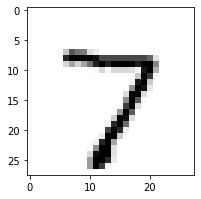

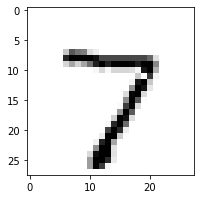

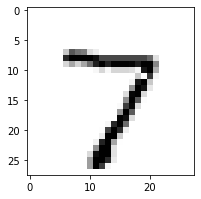

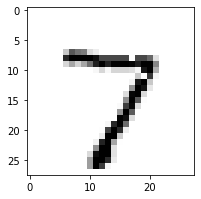

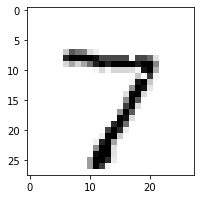

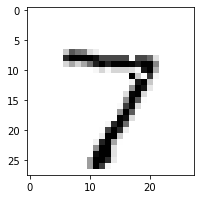

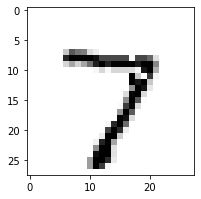

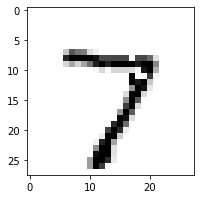

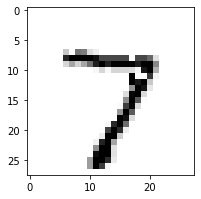

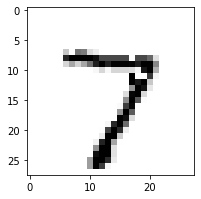

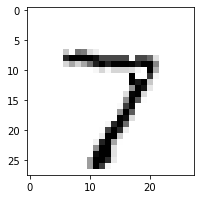

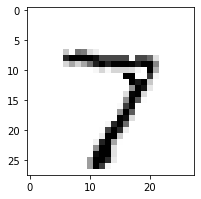

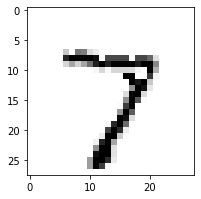

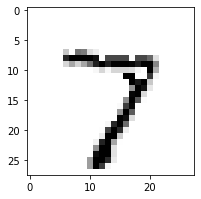

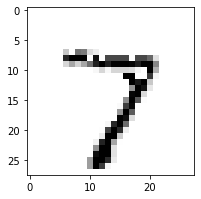

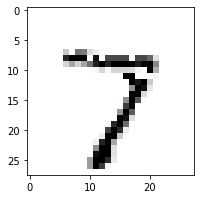

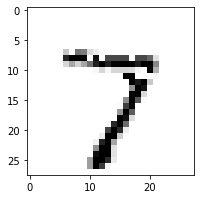

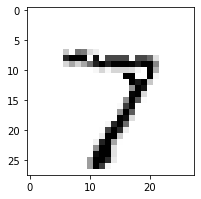

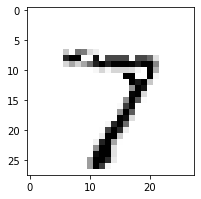

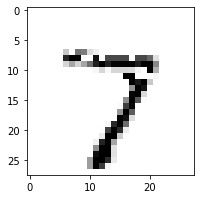

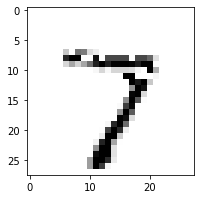

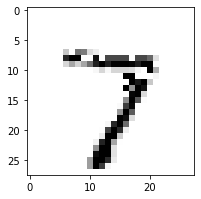

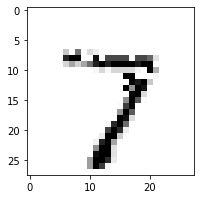

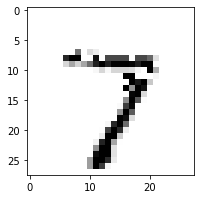

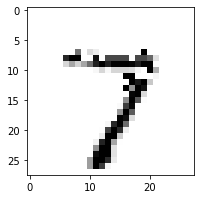

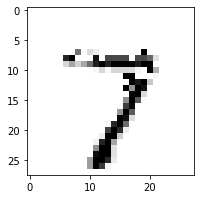

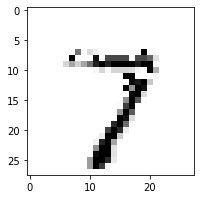

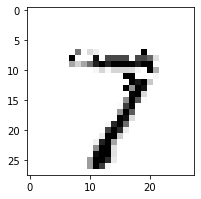

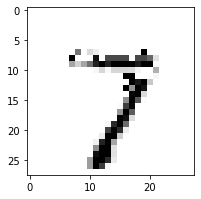

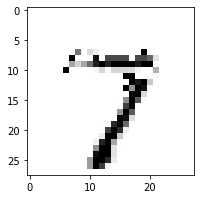

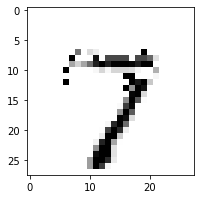

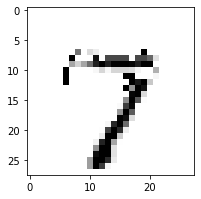

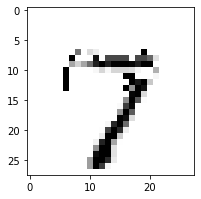

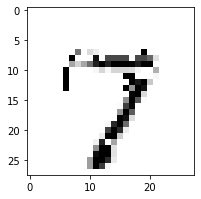

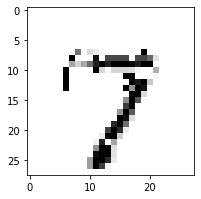

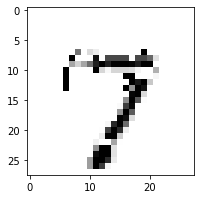

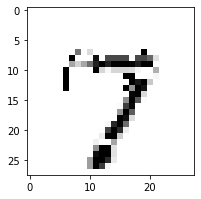

36


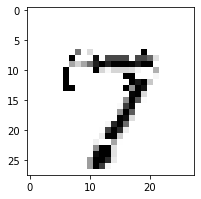

In [ ]:
K = 10
image = iter(test_loader).next()[0][0]
image = image.unsqueeze(0)
print(image.shape)
plot(image.detach().numpy()[0][0])
continue_it = True
nb_iter = 0
image = image.to(device)
image.requires_grad = True

mask = np.zeros((1,10))
mask[0, 9] = 1
mask = torch.tensor(mask).float().to(device)

while(continue_it) :
  image.requires_grad = True
  y = model_dropout(image)
  for i in range(1,K) :
    y.add(model_dropout(image))
  loss = y.mm(mask.t())
  loss.backward()
  im_grad = image.grad

  if np.argmax(y.cpu().detach().numpy()) == 9:
    continue_it = False
    print(nb_iter)
  
  nb_iter += 1
  with torch.no_grad():
    bow = torch.sign(image - torch.mean(image))
    grada = bow*im_grad
    ptbc = torch.argmin(grada)
    tensor = torch.zeros(image.shape).to(device)
    a = ptbc // 28
    b = ptbc % 28
    tensor[0, 0,  a, b] = 1
    gradient_sign = (2 * (im_grad >= 0) - 1).type(torch.float).to(device) # renvoie 1 si le gradient est positif, -1 s'il est négatif
    perturbed_image = image + 1 * gradient_sign * tensor
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clip(perturbed_image, 0, 1).to(device)
    image = perturbed_image

  model_dropout.zero_grad()
  plot(image.cpu().detach().numpy()[0][0])

Là aussi, bien solide sur les appusi, les résultats sont:

23

26

22

41

8

14

5

17